<a href="https://colab.research.google.com/github/Kaiziferr/ensemble_learning/blob/main/1_ensemble/boosting/xgboosting/01_Learning_Curves_XGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# Utils
# ==============================================================================
import warnings
from unicodedata import normalize

# Charts
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
# ==============================================================================
import pandas as pd

## Model
# ==============================================================================
from sklearn.model_selection import (
    train_test_split,
    RepeatedKFold,
    cross_val_score
)
from xgboost import XGBRegressor

# Metrics
# ==============================================================================
from sklearn.metrics import mean_absolute_error


#**INFO**
---
**@By**: **Steven Bernal**

**@Nickname**: **Kaiziferr**

**@Git**: https://github.com/Kaiziferr

# **CONFIG**
---


In [51]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
random_seed = 73
warnings.filterwarnings('ignore')

# **UTILS**
---

In [52]:
def normalize_word(word)->str:
  """Normaliza palabras"""
  word = word.replace(' ', '_')
  find_guion = word.find('_')
  list_word = []
  if find_guion:
    list_word = [w for w in word.split('_') if w != '']
  else:
    list_word = word
  word = list(map(lambda x: x.lower(), list_word))
  word = [normalize('NFKD', c).encode('ASCII', 'ignore').decode() for c in word]
  word = "_".join(word)
  return word

def normalize_name_columns(columns):
  """Normaliza columnas"""
  columns = list(map(lambda x: normalize_word(x), columns))
  return columns

def null_percentage_per_feature(data:pd.DataFrame, **kwargs)->None:
    """Calculate the percentage of null values per feature"""
    try:
        ticklabels = data.isnull().melt().pipe(
            lambda df: (
                sns.displot(
                    data=df,
                    y='variable',
                    hue='value',
                    multiple='fill',
                    aspect=5
                    ).set(**kwargs)
                )
            )
        p = (data.isnull().sum()/data.shape[0])
        for n, i in zip(p.index, range(p.shape[0])):
            if p[i] > 0:
                ticklabels.ax.text(p[n]+0.015, i+0.2, f'{round(p[n]*100, 2)}%', ha="center", color='w', fontweight='bold')
    except Exception as e:
        print(e)


The purpose of this notebook is to understand how to apply learning curves to detect underfitting or overfitting. For the purposes of the project, it will focus more on tuning and curves rather than on complex preprocessing.

# **Data**
---

In [53]:
url_master =  'https://drive.google.com/uc?id='
url_minero='https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'

url_minero =  url_master + url_minero.split('/')[-2]
data_miner = pd.read_csv(url_minero, dtype=str)
data_miner.head(2)

,Municipio Productor,Departamento,Recurso Natural,Nombre Del Proyecto,Año Produccion,Trimestre,Unidad Medida,Tipo Contraprestacion,Valor Contraprestacion,Cantidad Producción
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0
1,Medellin,Antioquia,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,2036781,14381


In [54]:
data_miner.columns = normalize_name_columns(data_miner.columns)
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

In [55]:
data_miner = data_miner.astype({
    'valor_contraprestacion': 'float64',
    'cantidad_produccion': 'float64',
    'valor_contraprestacion': 'float64',
    'cantidad_produccion': 'float64',
    'ano_produccion': 'int64',
})

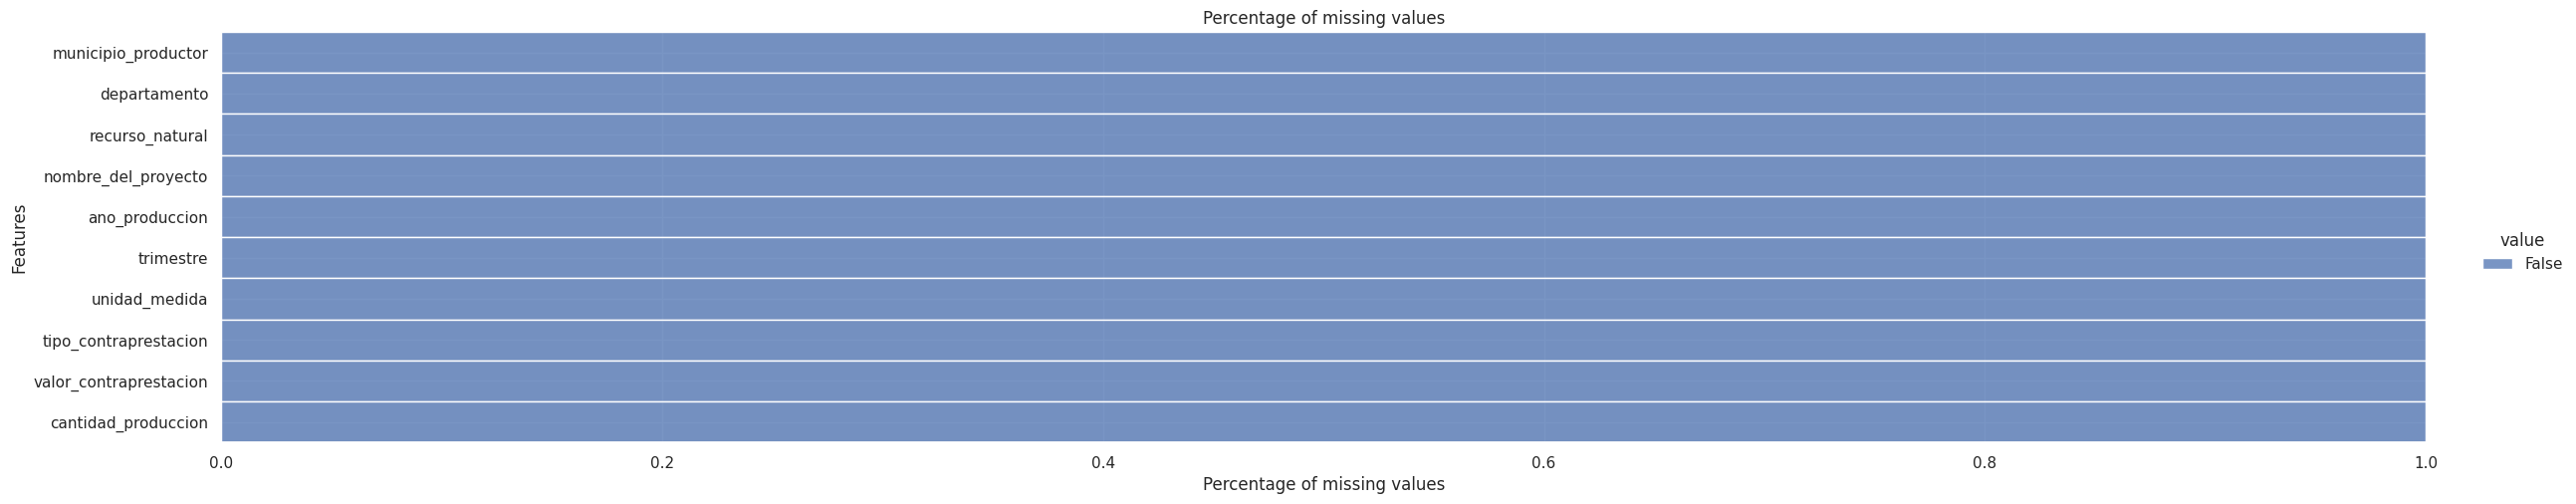

In [56]:
null_percentage_per_feature(
    data_miner,
    title="Percentage of missing values",
    xlabel='Percentage of missing values',
    ylabel='Features')

There are no null values

Information from the last six years will be taken

In [57]:
data_miner = data_miner[
    (data_miner['cantidad_produccion']>2017)
    &
    (data_miner['ano_produccion']<2024)
]

In [58]:
data_miner['ano_produccion'].value_counts()

,count
ano_produccion,
2016,3184
2018,3166
2017,3116
2019,3050
2013,2961
2015,2783
2014,2665
2021,2569
2022,2487


In [59]:
data_miner.columns

Index(['municipio_productor', 'departamento', 'recurso_natural',
       'nombre_del_proyecto', 'ano_produccion', 'trimestre', 'unidad_medida',
       'tipo_contraprestacion', 'valor_contraprestacion',
       'cantidad_produccion'],
      dtype='object')

A first grouping is made with respect to the municipality, department, year of production, and quarter. To obtain the total value of the compensation, the number of transactions, and the amount of production.

In [60]:
function_dictionary = {
    "valor_contraprestacion":["sum", "count"],
    "cantidad_produccion": ["sum"]
}

data_transaction = data_miner.groupby([
    'municipio_productor',
    'departamento',
    'ano_produccion',
    'trimestre'
]).aggregate(
    function_dictionary
)


data_transaction.columns = [
    'valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion',
    'valor_cantidad_produccion_sum',
]

data_transaction.reset_index(inplace=True)
data_transaction

,municipio_productor,departamento,ano_produccion,trimestre,valor_contraprestacion_sum,n_transacciones_valor_contraprestacion,valor_cantidad_produccion_sum
0,Abejorral,Antioquia,2012,Trimestre 4,"11,211,408.00",1,"88,140.00"
1,Abejorral,Antioquia,2013,Trimestre 1,"11,784,317.00",1,"92,644.00"
2,Abejorral,Antioquia,2013,Trimestre 4,"41,366,665.00",2,"320,641.00"
3,Abejorral,Antioquia,2014,Trimestre 1,"2,422,776.00",1,"17,110.00"
4,Abejorral,Antioquia,2014,Trimestre 3,"186,687.00",1,"2,550.00"
...,...,...,...,...,...,...,...
14856,Zona Bananera,Magdalena,2015,Trimestre 4,"2,147,946.00",4,"18,129.00"
14857,Zona Bananera,Magdalena,2016,Trimestre 4,"490,446.00",1,"2,599.00"
14858,Zona Bananera,Magdalena,2018,Trimestre 4,"1,021,506.00",2,"6,540.00"
14859,utica,Cundinamarca,2017,Trimestre 2,"1,020,942.00",1,"5,625.00"


Then, a second grouping is performed by producing municipalities and departments to obtain the total and quarterly average of the compensation value; the number of transactions and its quarterly average; the production quantity value and the average production per quarter; as well as the number of quarters and years of activity

In [61]:
function_dictionary = {
    'valor_contraprestacion_sum':['sum', 'mean'],
    'n_transacciones_valor_contraprestacion': ['sum', 'mean'],
    'valor_cantidad_produccion_sum': ['sum', 'mean'],
    'trimestre': ['count'],
    'ano_produccion': ['nunique'],
}

data_transaction_dos = data_transaction.groupby([
    'municipio_productor',
    'departamento',
]).aggregate(
    function_dictionary
)
data_transaction_dos.columns = [
    'valor_contraprestacion_sum',
    'valor_contraprestacion_mean',
    'n_transacciones_valor_contraprestacion_sum',
    'n_transacciones_valor_contraprestacion_mean',
    'valor_cantidad_produccion_sum',
    'valor_cantidad_produccion_mean',
    'n_trimestre',
    'n_ano_produccion'
]

data_transaction_dos.reset_index(inplace=True)
data_transaction_dos

,municipio_productor,departamento,valor_contraprestacion_sum,valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,n_transacciones_valor_contraprestacion_mean,valor_cantidad_produccion_sum,valor_cantidad_produccion_mean,n_trimestre,n_ano_produccion
0,Abejorral,Antioquia,"326,904,191.00","14,213,225.70",34,1.48,"2,708,181.00","117,747.00",23,11
1,Abrego,Norte de Santander,"37,983,382.00","1,266,112.73",30,1.00,"218,284.00","7,276.13",30,11
2,Abriaqui,Antioquia,"320,392,879.00","26,699,406.58",14,1.17,"60,509.00","5,042.42",12,7
3,Acacias,Meta,"1,045,249,597.00","24,308,130.16",110,2.56,"5,555,999.00","129,209.28",43,12
4,Acandi,Choco,"11,533,856,093.00","887,219,699.46",34,2.62,"3,213,666.00","247,205.08",13,5
...,...,...,...,...,...,...,...,...,...,...
723,Zaragoza,Antioquia,"77,941,808,685.00","1,694,387,145.33",242,5.26,"37,954,931.00","825,107.20",46,12
724,Zarzal,Valle del Cauca,"22,209,933.00","1,168,943.84",22,1.16,"157,781.00","8,304.26",19,10
725,Zipaquira,Cundinamarca,"4,824,817,230.00","112,205,051.86",85,1.98,"2,006,936.00","46,672.93",43,12
726,Zona Bananera,Magdalena,"5,798,086.00","1,159,617.20",11,2.20,"49,130.00","9,826.00",5,5


Since there are similar municipalities in different departments, they are concatenate the features for create a new unique key

In [62]:
data_transaction_dos['id'] = data_transaction_dos.municipio_productor.str.cat(
    data_transaction_dos.departamento, sep='-'
)

data_transaction_dos = data_transaction_dos.drop(['municipio_productor', 'departamento'], axis=1)

In [63]:
data_transaction_dos = data_transaction_dos.iloc[:, ::-1]
data_transaction_dos.head(3)

,id,n_ano_produccion,n_trimestre,valor_cantidad_produccion_mean,valor_cantidad_produccion_sum,n_transacciones_valor_contraprestacion_mean,n_transacciones_valor_contraprestacion_sum,valor_contraprestacion_mean,valor_contraprestacion_sum
0,Abejorral-Antioquia,11,23,"117,747.00","2,708,181.00",1.48,34,"14,213,225.70","326,904,191.00"
1,Abrego-Norte de Santander,11,30,"7,276.13","218,284.00",1.00,30,"1,266,112.73","37,983,382.00"
2,Abriaqui-Antioquia,7,12,"5,042.42","60,509.00",1.17,14,"26,699,406.58","320,392,879.00"


# **DATA SPLIT**
---

In [64]:
X = data_transaction_dos.drop(['id','valor_contraprestacion_sum'], axis=1)
y = data_transaction_dos['valor_contraprestacion_sum']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=random_seed,
    test_size=0.25
)

# **MODEL**
---

In [87]:
model = XGBRegressor(
    n_estimators = 500,
    max_depth = 7,
    eta=0.01,
    alpha = 5,
    eval_metric=mean_absolute_error
)

In [88]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=0
)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01,
             eval_metric=<function mean_absolute_error at 0x7cc40dbcbc40>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, ...)

The lists containing the training and validation error metrics are accessed in each iteration.



In [89]:
results = model.evals_result()
results.keys()

dict_keys(['validation_0', 'validation_1'])

In this graph, it is evident that the model has convergence at tree 75 with the configuration hyperparameters in the second instance of the model.

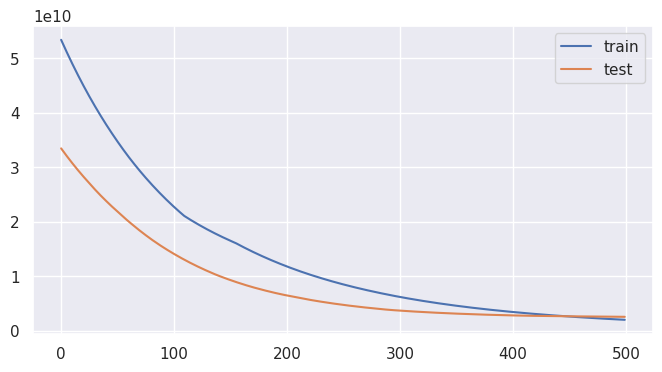

In [90]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(results['validation_0']['mean_absolute_error'], label='train')
ax.plot(results['validation_1']['mean_absolute_error'], label='test')
plt.legend()
plt.show()

The model was configured with 450 estimators, along with parameter settings, as there is a convergence between the error on the training data and the validation data.

In [91]:
model = XGBRegressor(
    n_estimators = 450,
    max_depth = 7,
    eta=0.01,
    alpha = 5,
    eval_metric=mean_absolute_error
)

In [92]:
model.fit(X_train, y_train)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01,
             eval_metric=<function mean_absolute_error at 0x7cc40dbcbc40>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=450, ...)

In [93]:
cv = RepeatedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=random_seed
)

In [94]:
cv

RepeatedKFold(n_repeats=3, n_splits=10, random_state=73)

In [95]:
scores = cross_val_score(
    model,
    X,
    y,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1
)

In [98]:
scores = abs(scores)

In [99]:
print('Mean MAE: {:0,.0f}, Std: {:0,.0f}'.format(scores.mean(), scores.std()))

Mean MAE: 14,613,983,801, Std: 17,780,469,185


In [100]:
y.describe()

,valor_contraprestacion_sum
count,728.00
mean,"25,583,058,816.14"
std,"251,452,439,388.43"
min,"11,448.00"
25%,"21,947,326.25"
50%,"138,981,089.50"
75%,"1,691,447,979.25"
max,"4,677,692,855,867.00"


In [101]:
y_predict = model.predict(X_test)
error = mean_absolute_error(y_test, y_predict)
print('Mean MAE: {:0,.2f}'.format(error))

Mean MAE: 2,637,596,955.36


#**Info**
---
@By: **Steven Bernal**

@Nickname: **Kaiziferr**

@Git: https://github.com/Kaiziferr